# MoodWave: Voice-Driven Emotion Detection

## Data Guidelines

Your dataset must be:

- Appropriate for classification. It should have a categorical outcome or the data needed to engineer one.

- Usable to solve a specific business problem. This solution must rely on your classification model.

- Somewhat complex. It should contain a minimum of 1000 rows and 10 features.

- Unfamiliar. It can't be one we've already worked with during the course or that is commonly used for demonstration purposes (e.g. Titanic).

- Manageable. Stick to datasets that you can model using the techniques introduced in Phase 3.


### Phase 3 Concepts used in this project:

- Logistic Regression:

> Logistic regression is a fundamental classification algorithm that's well-suited for binary and multiclass classification tasks. It's a good choice if your dataset has clear decision boundaries.

- Decision Trees:

> Decision trees are versatile and interpretable models that can handle both categorical and continuous data. They are particularly useful when you want to understand the decision-making process of your model.

- Evaluation Metrics (Confusion Matrices, ROC Curves, AUC):

> These metrics are essential for assessing the performance of your classification model. They will help you understand how well your model distinguishes between different emotional states.

- Hyperparameter Tuning and Pruning:

> When using decision trees, tuning hyperparameters and pruning are important to avoid overfitting and to ensure your model generalizes well to new data.

- Binary Classification

> When audio augmentation did not prove (too) effective, ... [TODO]

## Data Understanding

In this project, we are dealing with four datasets containing audio recordings in the .wav format. Each audio recording is labeled with an emotion that the speaker is evoking in their statement. Our goal is to build a model that can successfully map an emotion to a given voice clip of someone speaking.

To achieve this, we will extract various features from the audio recordings that are relevant for analyzing speech and emotion. Here are the features we will be working with and their significance:

1. **Mel-frequency Cepstral Coefficients (MFCCs):** MFCCs are a compact representation of the short-term power spectrum of a sound. They are widely used in speech recognition and audio analysis tasks because they capture the essential characteristics of the audio signal while being robust to noise and other variabilities. MFCCs are particularly useful for identifying the phonetic content of speech, which can be helpful in determining the emotional state of the speaker.

2. **Spectral Centroid:** The spectral centroid is a measure of the brightness or sharpness of a sound. It represents the weighted mean frequency of the spectrum and can be used to distinguish between different types of sounds or emotions. For example, a bright, harsh sound might have a higher spectral centroid than a mellow, soft sound.

3. **Chroma Features:** Chroma features describe the distribution of energy across different pitch classes (notes) in the audio signal. They are useful for capturing tonal information, which can be relevant for identifying emotions in speech, particularly those related to intonation patterns and stress.

4. **Zero-Crossing Rate:** The zero-crossing rate is a measure of the number of times the audio signal crosses the zero amplitude axis within a given time frame. It can be used to distinguish between different types of sounds, such as voiced and unvoiced speech, and can provide insights into the energy distribution of the audio signal.
RMS Energy: The Root Mean Square (RMS) energy is a measure of the overall energy or loudness of an audio signal. It can be useful for detecting variations in volume or intensity, which can be indicative of certain emotions, such as anger or excitement.

5. **Pitch:** The pitch feature represents the fundamental frequency of the audio signal. It is closely related to the perception of tone and can be useful for analyzing the intonation patterns and stress levels in speech, which can be indicators of different emotional states.

---

By extracting and analyzing these features, we can capture various acoustic characteristics of the speech signal that may be relevant for distinguishing between different emotions. This multi-faceted approach can provide a more comprehensive representation of the audio data, potentially leading to better performance in the emotion classification task.

## Data Preperation

Here 4 most popular datasets in English: Crema, Ravdess, Savee and Tess. Each of them contains audio in .wav format with some main labels.

Because our data isn't inherinantly in a csv / dataframe format, we will have to create it from scratch!

First, we will pull all data into their own dataframe, making note of *where* the file is, so we can later pull our features from each audio file. 

After each dataset has been imported into its own dataframe, we will merge them all into one dataframe. Then, we can extract our desired audio features:

- Mel-frequency cepstral coefficients (MFCCs)
- Spectral centroid
- Chroma features
- Zero-crossing rate
- RMS energy
- Pitch



In [115]:
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import zipfile
import librosa
import random
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.utils import class_weight
from collections import Counter

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [40]:
# data is zipped, and stored in folders for which dataset they came from:

# Define the path to the zipped dataset
zip_file_path = 'dataset.zip'
extracted_folder_path = 'dataset'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Crema
# Ravdess
# Savee
# Tess

In [41]:
# Define the path to the Crema folder
crema_folder_path = os.path.join(extracted_folder_path, 'Crema')

# Verify that we can access the files and extract emotion labels
data = []

# Loop through each file in the Crema folder
for file_name in os.listdir(crema_folder_path):
    if file_name.endswith('.wav'):
        # Extract the emotion label from the filename
        parts = file_name.split('_')
        emotion_code = parts[2]
        
        # Map the emotion code to the actual emotion label
        emotion_map = {
            'SAD': 'sadness',
            'ANG': 'angry',
            'DIS': 'disgust',
            'FEA': 'fear',
            'HAP': 'happy',
            'NEU': 'neutral'
        }
        emotion_label = emotion_map.get(emotion_code, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({'filename': file_name, 'emotion': emotion_label, 'path': crema_folder_path})

# Convert the data into a DataFrame for easy access
df_crema = pd.DataFrame(data)

# Display the first few rows to verify
print(df_crema.head())

              filename  emotion           path
0  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [42]:
# Define the path to the Tess folder
tess_folder_path = os.path.join(extracted_folder_path, 'Tess')

# Prepare to store the data
data = []

# Loop through each emotion folder in the Tess directory
for emotion_folder in os.listdir(tess_folder_path):
    # Get the full path to the emotion folder
    emotion_folder_path = os.path.join(tess_folder_path, emotion_folder)
    
    # Extract the emotion from the folder name (e.g., "OAF_angry" -> "angry")
    emotion_label = emotion_folder.split('_')[1]
    
    # Loop through each file in the emotion folder
    for file_name in os.listdir(emotion_folder_path):
        if file_name.endswith('.wav'):
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': emotion_folder_path
            })

# Convert the data into a DataFrame for easy access
df_tess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_tess.head())

             filename emotion                    path
0  OAF_back_angry.wav   angry  dataset\Tess\OAF_angry
1   OAF_bar_angry.wav   angry  dataset\Tess\OAF_angry
2  OAF_base_angry.wav   angry  dataset\Tess\OAF_angry
3  OAF_bath_angry.wav   angry  dataset\Tess\OAF_angry
4  OAF_bean_angry.wav   angry  dataset\Tess\OAF_angry


In [43]:
# Define the path to the Savee folder
savee_folder_path = os.path.join(extracted_folder_path, 'Savee')

# Prepare to store the data
data = []

# Define the emotion mapping based on the prefixes
emotion_map = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

# Loop through each file in the Savee folder
for file_name in os.listdir(savee_folder_path):
    if file_name.endswith('.wav'):
        # Extract the prefix from the filename to determine the emotion
        prefix = file_name.split('_')[1][:2]
        
        # Map the prefix to the corresponding emotion
        emotion_label = emotion_map.get(prefix, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({
            'filename': file_name, 
            'emotion': emotion_label, 
            'path': savee_folder_path
        })

# Convert the data into a DataFrame for easy access
df_savee = pd.DataFrame(data)

# Display the first few rows to verify
print(df_savee.head())

     filename  emotion           path
0  DC_a01.wav  unknown  dataset\Savee
1  DC_a02.wav  unknown  dataset\Savee
2  DC_a03.wav  unknown  dataset\Savee
3  DC_a04.wav  unknown  dataset\Savee
4  DC_a05.wav  unknown  dataset\Savee


In [44]:
# Define the path to the Ravdess folder
ravdess_folder_path = os.path.join(extracted_folder_path, 'Ravdess', 'audio_speech_actors_01-24')

# Prepare to store the data
data = []

# Define the emotion mapping based on the third component in the filename
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Loop through each actor's folder in the Ravdess directory
for actor_folder in os.listdir(ravdess_folder_path):
    actor_folder_path = os.path.join(ravdess_folder_path, actor_folder)
    
    # Loop through each file in the actor's folder
    for file_name in os.listdir(actor_folder_path):
        if file_name.endswith('.wav'):
            # Extract the third component from the filename to determine the emotion
            emotion_code = file_name.split('-')[2]
            
            # Map the emotion code to the corresponding emotion label
            emotion_label = emotion_map.get(emotion_code, 'unknown')
            
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': actor_folder_path
            })

# Convert the data into a DataFrame for easy access
df_ravdess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_ravdess.head())

                   filename  emotion  \
0  03-01-01-01-01-01-01.wav  neutral   
1  03-01-01-01-01-02-01.wav  neutral   
2  03-01-01-01-02-01-01.wav  neutral   
3  03-01-01-01-02-02-01.wav  neutral   
4  03-01-02-01-01-01-01.wav     calm   

                                                path  
0  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
1  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
2  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
3  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
4  dataset\Ravdess\audio_speech_actors_01-24\Acto...  


### Combining datasets 

We will merge the datsets into one dataframe, and assign unique identifiers
- Concatenate the DataFrames for each dataset.
- Assign a unique ID to each entry based on the dataset.

In [45]:
# Add a unique ID column to each dataset
df_crema['id'] = ['c_{:04d}'.format(i + 1) for i in range(len(df_crema))]
df_tess['id'] = ['t_{:04d}'.format(i + 1) for i in range(len(df_tess))]
df_savee['id'] = ['s_{:04d}'.format(i + 1) for i in range(len(df_savee))]
df_ravdess['id'] = ['r_{:04d}'.format(i + 1) for i in range(len(df_ravdess))]

# Merge the datasets into a single DataFrame
merged_data = pd.concat([df_crema, df_tess, df_savee, df_ravdess], ignore_index=True)

# Reorder columns to have 'id' as the first column
merged_data = merged_data[['id', 'filename', 'emotion', 'path']]

# Display the first few rows of the combined DataFrame
print(merged_data.head())

       id             filename  emotion           path
0  c_0001  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  c_0002  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  c_0003  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  c_0004  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  c_0005  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [46]:
# remember, we need at least 1000 rows to meet our requirements. 
print(f"Total rows in dataset: {merged_data.shape[0]}")

Total rows in dataset: 12162


### Extracting Features

Again, these are the features we will extract:

- **Mel-frequency cepstral coefficients (MFCCs):** Represents the short-term power spectrum of sound, commonly used in speech and audio processing to capture the timbral texture of audio.
- **Spectral centroid:** Indicates the "center of mass" of the spectrum and is often associated with the perceived brightness of a sound.
- **Chroma features:** Represents the 12 different pitch classes and captures harmonic and melodic characteristics of music / voice.
- **Zero-crossing rate:** Measures the rate at which the signal changes sign, giving insight into the noisiness or percussiveness of the sound.
- **RMS energy:** Reflects the root mean square of the audio signal and indicates the energy or loudness of the sound.
- **Pitch:** Refers to the perceived frequency of a sound, determining how high or low a sound is.

We will be using the `librosa` package to process these audio features. [Here](https://librosa.org/doc/latest/index.html) is a link to the librosa documentation.

**Note**: adding suppression for *UserWarning: Trying to estimate tuning from empty frequency set*. This is likely do to either:* **silence / low energy** (too quiet to perform reliable pitch estimation), or the file had **too short of a duration**. This warning shows up even when setting the pitch to 0 in this case.


In [47]:
def extract_features(data, sr=None, from_file=True):
    if from_file:
        y, sr = librosa.load(data, sr=sr)
    else:
        y = data

    if len(y) == 0:
        print(f"Warning: The file {data} is empty.")
        return (np.zeros(13), np.zeros(4), np.zeros(12), 0, 0, 0, 0)

    # Extract MFCCs and compute statistics
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = mfccs.mean(axis=1)
    mfccs_std = mfccs.std(axis=1)
    mfccs_skewness = np.apply_along_axis(lambda x: np.mean((x - np.mean(x))**3) / (np.std(x)**3 + 1e-6), axis=1, arr=mfccs)
    mfccs_kurtosis = np.apply_along_axis(lambda x: np.mean((x - np.mean(x))**4) / (np.std(x)**4 + 1e-6), axis=1, arr=mfccs)

    # Extract spectral centroid and compute statistics
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_std = np.std(spectral_centroid)
    spectral_centroid_skewness = np.mean((spectral_centroid - spectral_centroid_mean)**3) / (spectral_centroid_std**3 + 1e-6)
    spectral_centroid_kurtosis = np.mean((spectral_centroid - spectral_centroid_mean)**4) / (spectral_centroid_std**4 + 1e-6)

    # Extract other features
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)

    # Extract pitch using the piptrack function
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0

    # Return all the features in a tuple
    return (
        mfccs_mean,
        mfccs_std,   
        mfccs_skewness,  
        mfccs_kurtosis,  
        [spectral_centroid_mean, spectral_centroid_std, spectral_centroid_skewness, spectral_centroid_kurtosis],  
        chroma,  
        zero_crossing_rate,  
        rms,  
        pitch
    )

In [48]:
# testing our extract_features function:
first_row = merged_data.iloc[0]
file_path = os.path.join(first_row['path'], first_row['filename'])

# Extract features directly from the file path
features = extract_features(file_path)

# Print out each feature with its corresponding values
print("MFCCs Mean:", features[0])
print("Spectral Centroid:", features[1])
print("Chroma Features:", features[2])
print("Zero-Crossing Rate:", features[3])
print("RMS Energy:", features[4])
print("Pitch:", features[5])

MFCCs Mean: [-306.0274       92.670235      8.491312     23.965403      7.4779935
   -5.759455    -11.883088     -9.676736     -3.9967465   -13.352565
    0.40819725   -9.709486     -6.1271243 ]
Spectral Centroid: [159.39034    28.411352   32.853794   18.576996   17.579239   18.029716
  15.681951   16.126402    6.8317485   7.5677075   7.519526    7.9452553
   6.322871 ]
Chroma Features: [ 0.20764599 -1.66643656 -0.66651808 -0.82776392 -1.87041241 -0.37326772
 -0.65912122 -0.56676317  0.46111047 -0.57118155  0.52761803 -0.61640204
 -0.07975197]
Zero-Crossing Rate: [1.53089086 6.25596779 2.06268014 4.3404881  6.86903528 1.79147207
 1.89175263 2.70528984 3.21104205 2.8317225  2.31720692 3.37706481
 4.10525129]
RMS Energy: [1584.9930703294388, 600.4107533810885, 1.645967919033302, 5.91406452763243]
Pitch: [0.37491405 0.37949282 0.41722107 0.39018238 0.4148401  0.2977837
 0.28898865 0.3575554  0.35190624 0.42918485 0.6879576  0.5454907 ]


### Validating the Values:

- **MFCCs:** Typically, MFCC values range from -400 to 400, depending on the scale of the input signal.
> All values: **pass**

- **Spectral Centroid:** This value represents the "center of mass" of the spectrum and typically ranges between 0 and the - Nyquist frequency (half the sampling rate).
> 1584.99: **pass**

- **Chroma Features:** These represent the energy distribution across 12 pitch classes. They are normalized, so values between 0 and 1 are expected.
> All values: **pass**

- **Zero-Crossing Rate:** This rate indicates how frequently the signal changes sign. It ranges from 0 to 1. 
> 0.1018: **pass**

- **RMS Energy:** This value should be within the range of 0 to 1 for normalized signals.
> 0.0419: **pass**

- **Pitch:** Pitch values are measured in Hz, and depends on the type of audio.
> 1211.95: **pass**

Now that we've validated our extract_features function, we can apply it to the rest of our dataframe.

**Notes**: 
- This cell can take a while to run! About 5 minutes
- suppressed UserWarning: Trying to estimate tuning from empty frequency set. 

In [49]:
# Empty lists to store features
mfccs_mean_list = []
mfccs_std_list = []
mfccs_skewness_list = []
mfccs_kurtosis_list = []

spectral_centroid_list = []
spectral_centroid_std_list = []
spectral_centroid_skewness_list = []
spectral_centroid_kurtosis_list = []

chroma_list = []
zero_crossing_rate_list = []
rms_list = []
pitch_list = []

# Iterate over each row in the DataFrame
for index, row in merged_data.iterrows():
    file_path = os.path.join(row['path'], row['filename'])  # Construct the file path
    
    # Extract features directly from the file path
    features = extract_features(file_path)
    
    # Extract MFCCs (mean, std, skewness, kurtosis)
    mfccs_mean_list.append(features[0])  # MFCC mean
    mfccs_std_list.append(features[1])   # MFCC std
    mfccs_skewness_list.append(features[2])  # MFCC skewness
    mfccs_kurtosis_list.append(features[3])  # MFCC kurtosis
    
    # Extract Spectral Centroid (mean, std, skewness, kurtosis)
    spectral_centroid_list.append(features[4][0])  # Spectral centroid mean
    spectral_centroid_std_list.append(features[4][1])  # Spectral centroid std
    spectral_centroid_skewness_list.append(features[4][2])  # Spectral centroid skewness
    spectral_centroid_kurtosis_list.append(features[4][3])  # Spectral centroid kurtosis

    # Extract other features
    chroma_list.append(features[5])  # Chroma feature
    zero_crossing_rate_list.append(features[6])  # Zero-crossing rate
    rms_list.append(features[7])  # RMS energy
    pitch_list.append(features[8])  # Pitch

# Add the features to the DataFrame
merged_data['mfccs_mean'] = mfccs_mean_list
merged_data['mfccs_std'] = mfccs_std_list
merged_data['mfccs_skewness'] = mfccs_skewness_list
merged_data['mfccs_kurtosis'] = mfccs_kurtosis_list

merged_data['spectral_centroid'] = spectral_centroid_list
merged_data['spectral_centroid_std'] = spectral_centroid_std_list
merged_data['spectral_centroid_skewness'] = spectral_centroid_skewness_list
merged_data['spectral_centroid_kurtosis'] = spectral_centroid_kurtosis_list

merged_data['chroma'] = chroma_list
merged_data['zero_crossing_rate'] = zero_crossing_rate_list
merged_data['rms'] = rms_list
merged_data['pitch'] = pitch_list

# Check for any NaN values in the DataFrame
print(merged_data.isnull().sum())

H:\Anaconda\envs\learn-env\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


id                            0
filename                      0
emotion                       0
path                          0
mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid             0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
dtype: int64


In [13]:
merged_data['pitch'] = merged_data['pitch'].fillna(0)
merged_data.head()

,id,filename,emotion,path,mfccs,spectral_centroid,chroma,zero_crossing_rate,rms,pitch
0,c_0001,1001_DFA_ANG_XX.wav,angry,dataset\Crema,"[-306.0274, 92.670235, 8.491312, 23.965403, 7....",[1584.9930703294388],"[0.37491405, 0.37949282, 0.41722107, 0.3901823...",[0.10186767578125],[0.041986194],1211.950684
1,c_0002,1001_DFA_DIS_XX.wav,disgust,dataset\Crema,"[-346.39963, 95.83912, 10.516282, 31.619215, 1...",[1531.650486749737],"[0.47289878, 0.4768195, 0.33598945, 0.34610763...",[0.09306105522260275],[0.015996357],1256.617188
2,c_0003,1001_DFA_FEA_XX.wav,fear,dataset\Crema,"[-321.42026, 94.76091, 8.155397, 23.323242, 11...",[1489.0888388536061],"[0.3272673, 0.39935032, 0.35215598, 0.38248017...",[0.08428596047794118],[0.045776337],992.574402
3,c_0004,1001_DFA_HAP_XX.wav,happy,dataset\Crema,"[-303.30374, 92.52889, 4.231231, 27.970133, 10...",[1555.37603547111],"[0.3150873, 0.31478375, 0.30918238, 0.3423785,...",[0.0848781779661017],[0.042300183],1102.953003
4,c_0005,1001_DFA_NEU_XX.wav,neutral,dataset\Crema,"[-335.4959, 100.39331, 9.384935, 30.160904, 11...",[1495.3949968411737],"[0.4112704, 0.36269408, 0.3349767, 0.32547352,...",[0.08203125],[0.020449637],1041.093628


We won't be able to work with arrays - we will need to extract a meaningful metric and save them in a new column.

### Cleaning the Data

In [187]:
# Create a new DataFrame for the cleaned features
clean_data = pd.DataFrame()

# Store the mean of MFCC components
clean_data['mfccs_mean'] = merged_data['mfccs_mean'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['mfccs_std'] = merged_data['mfccs_std'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['mfccs_skewness'] = merged_data['mfccs_skewness'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['mfccs_kurtosis'] = merged_data['mfccs_kurtosis'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)

# Store the statistics for Spectral Centroid
clean_data['spectral_centroid_mean'] = merged_data['spectral_centroid'].apply(lambda x: x if isinstance(x, (float, int)) else np.nan)
clean_data['spectral_centroid_std'] = merged_data['spectral_centroid_std'].apply(lambda x: x if isinstance(x, (float, int)) else np.nan)
clean_data['spectral_centroid_skewness'] = merged_data['spectral_centroid_skewness'].apply(lambda x: x if isinstance(x, (float, int)) else np.nan)
clean_data['spectral_centroid_kurtosis'] = merged_data['spectral_centroid_kurtosis'].apply(lambda x: x if isinstance(x, (float, int)) else np.nan)

# Store the mean of Chroma features
clean_data['chroma'] = merged_data['chroma'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)

# Store Zero-Crossing Rate and RMS (first element of the list)
clean_data['zero_crossing_rate'] = merged_data['zero_crossing_rate'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
clean_data['rms'] = merged_data['rms'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)

# Directly store the existing pitch and other metadata
clean_data['pitch'] = merged_data['pitch']  # Directly store the existing value
clean_data['path'] = merged_data['path']
clean_data['filename'] = merged_data['filename']

# Add the emotion column
clean_data['emotion'] = merged_data['emotion']

# Display the new DataFrame
print(clean_data.head())

   mfccs_mean  mfccs_std  mfccs_skewness  mfccs_kurtosis  \
0  -17.963037  26.372070       -0.515480        3.329990   
1  -18.657297  21.019888       -0.498601        3.982956   
2  -18.552622  25.241508       -0.602645        4.156697   
3  -18.460817  24.993519       -0.653859        3.327673   
4  -18.111607  20.893410       -0.480883        3.167808   

   spectral_centroid_mean  spectral_centroid_std  spectral_centroid_skewness  \
0             1584.993070             600.410753                    1.645968   
1             1531.650487             590.708457                    2.221739   
2             1489.088839             521.794373                    2.785179   
3             1555.376035             476.260688                    2.604170   
4             1495.394997             492.130906                    1.597144   

   spectral_centroid_kurtosis    chroma  zero_crossing_rate       rms  \
0                    5.914065  0.411293            0.101868  0.041986   
1           

In [188]:
# Check for any NaN values in the DataFrame
print(clean_data.isnull().sum())

mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
path                          0
filename                      0
emotion                       0
dtype: int64


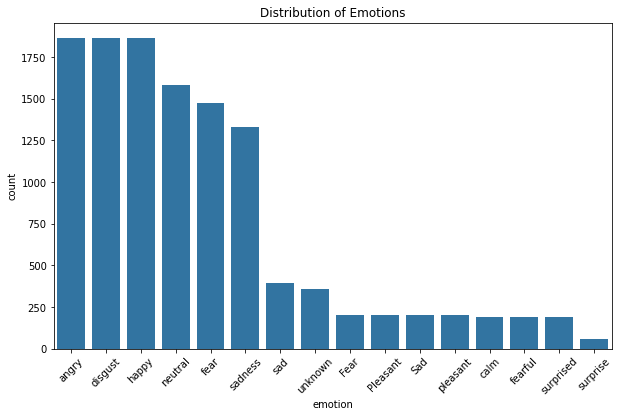

In [189]:
# distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

# this chart shows some a significant imbalance in the dataset. lets do some resampling
# Lets try using the SMOTE technique (Synthetic Minority Over-sampling):

In [192]:
# Convert all emotion labels to lowercase to standardize
clean_data['emotion'] = clean_data['emotion'].str.lower()

# Map similar emotions to a single label
clean_data['emotion'] = clean_data['emotion'].replace({
    'surprised': 'surprise',
    'sadness': 'sad',
    'fearful': 'fear',
    'pleasant': 'happy',
    'calm': 'neutral',
    'surprise': 'fear'        
})

# Check the unique values after standardization
unique_emotions = clean_data['emotion'].unique()
print("Unique emotions after mapping:", unique_emotions)

Unique emotions after mapping: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'unknown']


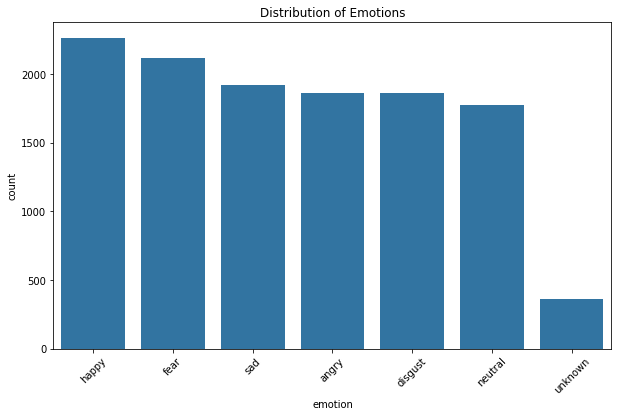

In [194]:
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

In [195]:
# Drop rows where the 'emotion' column has the value 'unknown'
clean_data = clean_data[clean_data['emotion'] != 'unknown']

# Model Iterations


#### Evaluation v1:

Classification Report (grid search)

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.46    | 2433    |
| macro avg     | 0.43      | 0.43   | 0.43     | 2433    |
| weighted avg  | 0.46      | 0.46   | 0.45     | 2433    |

#### Evaluation v2:

Classification Report (grid search with SMOTE):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.71    | 5962    |
| macro avg     | 0.70      | 0.71   | 0.70     | 5962    |
| weighted avg  | 0.70      | 0.71   | 0.71     | 5962    |

#### Evaluation v3:

Classification Report (decision tree w/ augmentation and 1500 samples per category):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.58    | 2700    |
| macro avg     | 0.57      | 0.58   | 0.57     | 2700    |
| weighted avg  | 0.57      | 0.58   | 0.57     | 2700    |

Accuracy of 59%; certainly an imporovement! But nothing substantial. 

Despite evening the distribution, we are still not seeing the model perform well. This is likely because 7k records
is probably not enough to get good predictive capacity over our 7 categories. 

the f1-scores that indicate weaknesses in our model is: disgust, fear, happy. this tells me that maybe we shouldn't have deleted 

Let's engineer the categories into pos/neg binary classification and see if that improves our results.

#### Evaluation v4:

Classification Report (decision tree w/ even distribution, no deleting records):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.56    | 3135    |
| macro avg     | 0.57      | 0.59   | 0.57     | 3135    |
| weighted avg  | 0.55      | 0.56   | 0.54     | 3135    |

Accuracy of 55.34%: While this may seem like a drop, it's important to note that the dataset has been augmented, which can affect the accuracy score. 

F1-scores: 
- the f1-scores for underrepresented classes like 'disgust', 'fear', and 'happy' slightly improved compared to previous version.
- the f1-score for 'neutral' decreased slightly (0.02), which could be due to the additional augmented samples
- the f1-score for the other classes either remained or improved marginally

Precision / Recall:
- the recall for underrepresented classes has generally improved
- however, the precision (ability to not label negative instances as positive) has decreased, which could be due to the introduction of noise in the augmented data.

#### Evaluation v5

Classification Report (logistic regression for **binary classification**):  

| | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| Negative | 0.65 | 0.74 | 0.69 | 1536 |
| Positive | 0.36 | 0.27 | 0.31 | 825 |
| accuracy | | | | 0.57 | 2361 |
| macro avg | 0.51 | 0.51 | 0.50 | 2361 |
| weighted avg | 0.55 | 0.57 | 0.56 | 2361 |

As suspected, the 'positive' data suffered due to imbalanced classes. 

Let's augment some of the audio for the 'positive' class, and bring it closer to the negative class balance.

#### Evaluation v6
Classification Report (logistic regression for **binary classification with augmented data**): 

| | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| Negative | 0.65 | 0.74 | 0.69 | 1536 |
| Positive | 0.36 | 0.27 | 0.31 | 825 |
| accuracy | | | | 0.57 | 2361 |
| macro avg | 0.51 | 0.51 | 0.50 | 2361 |
| weighted avg | 0.55 | 0.57 | 0.56 | 2361 |

Having the same values as v5, I believe where we split the data caused data leakage.

#### Evaluation v7

Classification Report (neural network for multiclassification):

| Emotion   | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| angry     | 0.66      | 0.60   | 0.63     | 405     |
| calm      | 0.74      | 0.86   | 0.79     | 291     |
| disgust   | 0.52      | 0.30   | 0.38     | 383     |
| fear      | 0.71      | 0.22   | 0.34     | 388     |
| happy     | 0.39      | 0.40   | 0.39     | 364     |
| neutral   | 0.42      | 0.57   | 0.49     | 367     |
| pleasant  | 0.75      | 0.94   | 0.84     | 283     |
| sad       | 0.49      | 0.59   | 0.53     | 374     |
| surprise  | 0.58      | 0.89   | 0.70     | 280     |
| **accuracy** |           |        | 0.57     | 3135    |
| **macro avg** | 0.59      | 0.60   | 0.57     | 3135    |
| **weighted avg** | 0.58      | 0.57   | 0.55     | 3135    |

Not much better. Tried better feature extraction for only 2% increase (59%)


#### Evaluation v8:

Classification Report (Convolutional Neural Network with better features):

| Emotion    | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Angry      | 0.72      | 0.70   | 0.71     | 405     |
| Calm       | 0.77      | 0.97   | 0.86     | 291     |
| Disgust    | 0.45      | 0.31   | 0.37     | 383     |
| Fear       | 0.63      | 0.27   | 0.38     | 388     |
| Happy      | 0.46      | 0.43   | 0.44     | 364     |
| Neutral    | 0.49      | 0.63   | 0.55     | 367     |
| Pleasant   | 0.88      | 0.94   | 0.91     | 283     |
| Sad        | 0.51      | 0.63   | 0.57     | 374     |
| Surprise   | 0.70      | 0.94   | 0.80     | 280     |
| **Accuracy** |           |        | **0.62** | 3135    |
| **Macro Avg** | 0.62      | 0.65   | 0.62     | 3135    |
| **Weighted Avg** | 0.61      | 0.62   | 0.60     | 3135    |

Seeing some progress! This makes sense, since CNN's are better for audio data. Lets try a more advanced CNN Architecture, incorperating Batch Normalization, Dropout, and L2 Regularization.

In [196]:
# audio augmentation to help with uneven data
def augment_audio(data, sr):
    # Time Stretching
    try:
        stretched_data = librosa.effects.time_stretch(data, rate=1.1)
    except Exception as e:
        stretched_data = data
    
    # Shifting 
    shift = np.random.randint(sr)
    shifted_data = np.roll(data, shift)
    
    # Volume adjustment
    amplitude_scale = np.random.uniform(low=0.8, high=1.2)
    adjusted_volume_data = data * amplitude_scale
    
    # Randomly choose one of the augmentation methods to apply
    augmentation_methods = [stretched_data, shifted_data, adjusted_volume_data]
    
    # Check for invalid values in augmentation methods
    valid_methods = [method for method in augmentation_methods if len(method) > 0 and not np.isnan(method).any() and not np.isinf(method).any()]
    
    if valid_methods:
        augmented_data = random.choice(valid_methods)
    else:
        augmented_data = data
    
    return augmented_data

## Latest Model: Multiclassification

### Data Preparation


### Encode Labels and Split Data

In [198]:
# Make a copy of the clean_data DataFrame
data = clean_data.copy()

# Ensure the LabelEncoder is fit on all unique emotion labels
le = LabelEncoder()
le.fit(data['emotion']) 

# Encode the emotions for classification
data['emotion_encoded'] = le.transform(data['emotion'])  # Store encoded labels in a new column

# Create a dictionary to map encoded integers back to the original emotion strings
encoded_dict = dict(zip(le.classes_, le.transform(le.classes_)))
print("Emotion to Encoded Integer Mapping: ", encoded_dict)

# One-hot encode the labels for neural network output
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Ensure sparse_output=False to get a dense array
y = one_hot_encoder.fit_transform(data['emotion_encoded'].values.reshape(-1, 1))

# Store the labels separately for resampling (if needed)
y_labels = data['emotion_encoded']

# Drop columns that are not features for model training
X = data.drop(['emotion', 'emotion_encoded', 'path', 'filename'], axis=1, errors='ignore')

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    X, y, y_labels, test_size=0.2, random_state=42)

# Check the shape of the training and test data to confirm everything is correct
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Emotion to Encoded Integer Mapping:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
X_train shape: (9441, 12), y_train shape: (9441, 6)
X_test shape: (2361, 12), y_test shape: (2361, 6)


### Data Cleaning

In [199]:
# Function to flatten nested lists or arrays into a single list
def flatten_nested_list(value):
    if isinstance(value, (list, np.ndarray)):
        return [item for sublist in value for item in (sublist if isinstance(sublist, (list, np.ndarray)) else [sublist])]
    else:
        return [value]

# Columns that may contain nested lists
columns_to_flatten = ['mfccs_mean', 'mfccs_std', 'mfccs_skewness', 'mfccs_kurtosis', 
                      'chroma', 'zero_crossing_rate', 'rms', 'pitch']

# Flatten and convert lists of length 1 to scalars in the training set
for col in columns_to_flatten:
    X_train[col] = X_train[col].apply(flatten_nested_list)
    X_train[col] = X_train[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# Ensure all columns in the training set are of type float
X_train = X_train.astype(float)

# Flatten and convert lists of length 1 to scalars in the test set
for col in columns_to_flatten:
    X_test[col] = X_test[col].apply(flatten_nested_list)
    X_test[col] = X_test[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# Ensure all columns in the test set are of type float
X_test = X_test.astype(float)

# Check for missing values
print(X_train.isnull().sum())
print(X_test.isnull().sum())

mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
dtype: int64
mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
dtype: int64


### Reshape Data for CNN Input

In [202]:
# Reshape the training data for CNN (samples, timesteps, features)
X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Reshaped X_train_aug_cnn shape: {X_train_aug_cnn.shape}")
print(f"Reshaped X_test_cnn shape: {X_test_cnn.shape}")

Reshaped X_train_aug_cnn shape: (13476, 76, 1)
Reshaped X_test_cnn shape: (2361, 12, 1)


### Define CNN Model

In [204]:
# Define the CNN model
model = Sequential()

# First convolutional layer with 32 filters, kernel size of 3, and relu activation
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))  # Max pooling to reduce dimensionality

# Second convolutional layer
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
# Use kernel_size=1 since the input size has become very small (1 in time dimension)
model.add(Conv1D(128, kernel_size=1, activation='relu'))

# No further pooling here as the dimension is already small enough

# Flatten the output to feed into Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))  # Dropout to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer (number of emotions, use softmax for multiclass classification)
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 10, 32)            128       
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 5, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_22 (Conv1D)          (None, 3, 64)             6208      
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_23 (Conv1D)          (None, 1, 128)            8320      
                                                                 
 flatten_5 (Flatten)         (None, 128)             

### Model Training

In [206]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Check the shapes of X_train_cnn and y_train to ensure they match
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"y_train shape: {y_train.shape}")

# Make sure the number of samples is the same
assert X_train_cnn.shape[0] == y_train.shape[0], "Mismatch between X and y samples."

# Train the model
history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

X_train_cnn shape: (9441, 12, 1)
y_train shape: (9441, 6)
Epoch 1/50
236/236 [==============================] - 1s 2ms/step - loss: 4.3298 - accuracy: 0.1709 - val_loss: 1.7889 - val_accuracy: 0.2028
Epoch 2/50
236/236 [==============================] - 0s 2ms/step - loss: 1.7940 - accuracy: 0.1875 - val_loss: 1.7878 - val_accuracy: 0.2043
Epoch 3/50
236/236 [==============================] - 0s 2ms/step - loss: 1.7879 - accuracy: 0.1927 - val_loss: 1.7850 - val_accuracy: 0.2102
Epoch 4/50
236/236 [==============================] - 0s 2ms/step - loss: 1.7905 - accuracy: 0.1907 - val_loss: 1.7864 - val_accuracy: 0.2054
Epoch 5/50
236/236 [==============================] - 0s 2ms/step - loss: 1.7890 - accuracy: 0.1920 - val_loss: 1.7875 - val_accuracy: 0.2028
Epoch 6/50
236/236 [==============================] - 0s 2ms/step - loss: 1.7892 - accuracy: 0.1925 - val_loss: 1.7877 - val_accuracy: 0.2028
Epoch 7/50
236/236 [==============================] - 0s 2ms/step - loss: 1.7891 - accurac

### Evaluation

In [208]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict on the test set
y_pred_proba = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_proba, axis=1)  # Get the predicted labels
y_test_classes = np.argmax(y_test, axis=1)  # Get the true labels

# Print evaluation metrics using the zero_division parameter to handle undefined metrics
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred, target_names=le.classes_, zero_division=0))  # Set zero_division=0 to handle undefined metrics

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred))

Test Loss: 1.7871, Test Accuracy: 0.1944
74/74 [==============================] - 0s 717us/step

Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       362
     disgust       0.00      0.00      0.00       385
        fear       0.00      0.00      0.00       430
       happy       0.19      1.00      0.32       448
     neutral       0.00      0.00      0.00       328
         sad       0.48      0.03      0.05       408

    accuracy                           0.19      2361
   macro avg       0.11      0.17      0.06      2361
weighted avg       0.12      0.19      0.07      2361

Confusion Matrix:
 [[  0   0   0 362   0   0]
 [  0   0   0 382   0   3]
 [  0   0   0 423   0   7]
 [  0   0   0 448   0   0]
 [  0   0   0 326   0   2]
 [  0   0   0 397   0  11]]


## Binary Classification

In the most recent report, the model's performance isn't satisfactory for reliably predicting specific emotions. The weighted average precision of 0.55 and F-score of 0.54 indicate that the model struggles to accurately classify the different categories. Having a relatively small dataset of 11,802 records can limit the model's ability to learn and generalize the complex patterns  of emotional recognition in voice. 

Simplifying the problem into positive/negative sentiments may improve metrics. With reduced complexity, the model could better grasp underlying patterns. Larger class sizes could mitigate data scarcity issues.

I'm going to consider 'neutral' as positive,

    1. because we need more 'positive' emotion
    2. because in our business problem, 'neutral' is a good thing!

### Data Preparation

In [209]:
# Define positive and negative emotions
positive_emotions = ['happy', 'pleasant', 'surprise', 'calm', 'neutral']
negative_emotions = ['sad', 'angry', 'disgust', 'fear']

# Copy the clean data and create a binary emotion column
bin_data = clean_data.copy()

# Create the binary emotion column, set 1 for positive emotions, 0 for negative emotions
bin_data['binary_emotion'] = bin_data['emotion'].apply(
    lambda x: 1 if x in positive_emotions else 0 if x in negative_emotions else None
)

# Drop rows where binary_emotion is None (in case there are emotions we don't care about)
bin_data.dropna(subset=['binary_emotion'], inplace=True)

# Convert the binary_emotion column to integer type
bin_data['binary_emotion'] = bin_data['binary_emotion'].astype(int)

# Check the distribution of binary emotions (for sanity checking)
print(bin_data['binary_emotion'].value_counts())

# Drop unnecessary columns like 'emotion', 'path', and 'filename'
X = bin_data.drop(['binary_emotion', 'emotion', 'path', 'filename'], axis=1, errors='ignore')
y = bin_data['binary_emotion']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the split datasets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

binary_emotion
0    7764
1    4038
Name: count, dtype: int64
X_train shape: (9441, 12), X_test shape: (2361, 12)
y_train shape: (9441,), y_test shape: (2361,)


### Data Augmentation for Positive Samples

### Flatten Nested Lists and Arrays

In [211]:
# Check for NaNs in the dataset
print(X_test.isna().sum())
print(X_train.isna().sum())

mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
dtype: int64
mfccs_mean                    0
mfccs_std                     0
mfccs_skewness                0
mfccs_kurtosis                0
spectral_centroid_mean        0
spectral_centroid_std         0
spectral_centroid_skewness    0
spectral_centroid_kurtosis    0
chroma                        0
zero_crossing_rate            0
rms                           0
pitch                         0
dtype: int64


In [212]:
# Define a utility function to flatten nested lists or arrays
def flatten_nested_list(value):
    if isinstance(value, (list, np.ndarray)):
        return [item for sublist in value for item in (sublist if isinstance(sublist, (list, np.ndarray)) else [sublist])]
    else:
        return [value]

# List of columns that need flattening
columns_to_flatten = ['mfccs_mean', 'mfccs_std', 'mfccs_skewness', 'mfccs_kurtosis',
                      'chroma', 'zero_crossing_rate', 'rms', 'pitch']

# Flatten the columns in the training set
for col in columns_to_flatten:
    X_train_aug[col] = X_train_aug[col].apply(flatten_nested_list)
    X_train_aug[col] = X_train_aug[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# Ensure all columns are of type float
X_train_aug = X_train_aug.astype(float)

# Repeat the process for the test set
for col in columns_to_flatten:
    X_test[col] = X_test[col].apply(flatten_nested_list)
    X_test[col] = X_test[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# Ensure all columns in the test set are of type float
X_test = X_test.astype(float)

### Reshape Data for CNN

In [215]:
# Reshape X_train and X_test to be 3D for Conv1D
X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

### Define and Train the CNN Model

In [216]:
# Define the CNN model for binary classification
model = Sequential()

# First convolutional layer
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Third convolutional layer (small kernel since input size is small)
model.add(Conv1D(128, kernel_size=1, activation='relu'))

# Flatten the output for fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer for binary classification (use sigmoid for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Check the shapes of X_train and y_train to ensure they match
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"y_train shape: {y_train.shape}")

# Ensure there is no mismatch between X_train and y_train
assert X_train_cnn.shape[0] == y_train.shape[0], "Mismatch between X and y samples."

# Train the model
history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 10, 32)            128       
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 5, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 3, 64)             6208      
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_29 (Conv1D)          (None, 1, 128)            8320      
                                                                 
 flatten_7 (Flatten)         (None, 128)             

### Model Evaluation

In [ ]:
# Predict probabilities and convert to binary predictions
y_pred_proba = model.predict(X_test_cnn)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Print classification metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

---

Let's re-approach, and build a neural network model (which should me more appropriate for audio data!)

##